In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/corvolin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [115]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.datasets import load_files
import statistics
import pickle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

from numpy import array
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [102]:
t0 = time()
dataCSV = pd.read_csv('data/extracted-flast.csv')
# only take raw and is_flakey column
data = dataCSV[['id','raw','is_flaky']]

# drop rows with empty raw content
data['raw'].replace('', np.nan, inplace=True)
data.dropna(subset=['raw'], inplace=True)
print(data.describe())


print("done in %0.3fs." % (time() - t0))

projectList = ['ninja','jackrabbit-oak','okhttp','wro4j','oryx','hadoop','alluxio-tachyon','oozie','pinto-ds','spring-boot','jimfs','togglz']
projectDF = []

for projectName in projectList:
    projectDF.append(data[data.id.str.contains(projectName+':')])

for df in projectDF:
    print(df.shape)
    counter = df['is_flaky'].value_counts()
    print(counter.get(0))

                                                       id  \
count                                               30848   
unique                                              30848   
top     jackrabbit-oak:org.apache.jackrabbit.oak.spi.s...   
freq                                                    1   

                                                      raw is_flaky  
count                                               30848    30848  
unique                                              27962        2  
top     WroTestUtils.assertProcessorSupportResourceTyp...    False  
freq                                                    9    28063  
done in 0.557s.
(954, 3)
936
(9218, 3)
9210
(1547, 3)
1481
(1013, 3)
1003
(385, 3)
372
(3264, 3)
2959
(2737, 3)
2733
(1170, 3)
314
(2803, 3)
1401
(6817, 3)
6803
(455, 3)
448
(398, 3)
387


In [89]:
outDir = "data/"
outFile = "tf-idf.csv"

with open(os.path.join(outDir, outFile), "w") as fo:
        fo.write("dataset,flakyTrain,nonFlakyTrain,flakyTest,nonFlakyTest,precision,recall,f1-score,fbeta-score,preparationTime,predictionTime\n")

In [134]:
# go through each project
for dfIndex, df in enumerate(projectDF):
    
    t0 = time()
    df.reset_index(drop=True, inplace=True)
    flakyTrain = []
    nonFlakyTrain = []
    flakyTest = []
    nonFlakyTest = []
    precision = []
    recall = []
    f1list = []
    fbetalist = []
    predTime = []
    data_target = df['is_flaky']
    #print(data_target.value_counts().get(0))

    tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
    vector_raw = tfidfconverter.fit_transform(df['raw'])
    vector_array = vector_raw.toarray()

    # use pca dimensionality reduction
    n_pc = 30
    pca = PCA(n_components=n_pc , random_state=0)
    pca.fit(vector_array)
    pca_val = pca.transform(vector_array)

    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    prepTime = time() - t0
    
    for train, test in kf.split(pca_val):
        t0 = time()
        #print('train: %s, test: %s' % (train, test))
        X_train, X_test = pca_val[train], pca_val[test]
        print(pca_val.shape)
        print(data_target.shape)
        print(train.shape)
        print(test.shape)
        y_train, y_test = data_target[train], data_target[test]
        #print(y_train.value_counts())
        if y_train.value_counts().get(1) == None:
            flakyTrain.append(0)
        else:
            flakyTrain.append(y_train.value_counts().get(1))

        nonFlakyTrain.append(y_train.value_counts().get(0))

        if y_test.value_counts().get(1) == None:
            flakyTest.append(0)
        else:
            flakyTest.append(y_test.value_counts().get(1))
            
        nonFlakyTest.append(y_test.value_counts().get(0))

        classifier.fit(X_train, y_train) 
        y_pred = classifier.predict(X_test)

        precision.append(precision_score(y_test, y_pred, average='weighted'))
        recall.append(recall_score(y_test, y_pred, average='weighted'))
        f1list.append(f1_score(y_test, y_pred, average='weighted'))
        fbetalist.append(fbeta_score(y_test, y_pred, average='weighted', beta=0.5))
        predTime.append(time()-t0)
    """
    print(projectList[dfIndex])
    print(statistics.mean(flakyTrain))
    print(statistics.mean(nonFlakyTrain))
    print(statistics.mean(flakyTest))
    print(statistics.mean(nonFlakyTest))
    print(statistics.mean(precision))
    print(statistics.mean(recall))
    print(statistics.mean(f1list))
    print(statistics.mean(fbetalist))
    print(prepTime)
    print(statistics.mean(predTime))
    """
    with open(os.path.join(outDir, outFile), "a") as fo:
        fo.write("{},{},{},{},{},{},{},{},{},{},{}\n".format(projectList[dfIndex], statistics.mean(flakyTrain), statistics.mean(nonFlakyTrain), statistics.mean(flakyTest), statistics.mean(nonFlakyTest), statistics.mean(precision), statistics.mean(recall), statistics.mean(f1list), statistics.mean(fbetalist), prepTime, statistics.mean(predTime)))


(954, 30)
(954,)
(763,)
(191,)
(954, 30)
(954,)
(763,)
(191,)
(954, 30)
(954,)
(763,)
(191,)
(954, 30)
(954,)
(763,)
(191,)
(954, 30)
(954,)
(764,)
(190,)
(9218, 30)
(9218,)
(7374,)
(1844,)
(9218, 30)
(9218,)
(7374,)
(1844,)
(9218, 30)
(9218,)
(7374,)
(1844,)
(9218, 30)
(9218,)
(7375,)
(1843,)
(9218, 30)
(9218,)
(7375,)
(1843,)
(1547, 30)
(1547,)
(1237,)
(310,)
(1547, 30)
(1547,)
(1237,)
(310,)
(1547, 30)
(1547,)
(1238,)
(309,)
(1547, 30)
(1547,)
(1238,)
(309,)
(1547, 30)
(1547,)
(1238,)
(309,)
(1013, 30)
(1013,)
(810,)
(203,)
(1013, 30)
(1013,)
(810,)
(203,)
(1013, 30)
(1013,)
(810,)
(203,)
(1013, 30)
(1013,)
(811,)
(202,)
(1013, 30)
(1013,)
(811,)
(202,)
(385, 30)
(385,)
(308,)
(77,)
(385, 30)
(385,)
(308,)
(77,)
(385, 30)
(385,)
(308,)
(77,)
(385, 30)
(385,)
(308,)
(77,)
(385, 30)
(385,)
(308,)
(77,)
(3264, 30)
(3264,)
(2611,)
(653,)
(3264, 30)
(3264,)
(2611,)
(653,)
(3264, 30)
(3264,)
(2611,)
(653,)
(3264, 30)
(3264,)
(2611,)
(653,)
(3264, 30)
(3264,)
(2612,)
(652,)
(2737, 30)
(273

In [8]:
t0 = time()
# use tf-idf vectorizer from sklearn
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
vector_raw = tfidfconverter.fit_transform(data_raw)

print("done in %0.3fs." % (time() - t0))

In [59]:
# https://stackabuse.com/text-classification-with-python-and-scikit-learn/
# that website suggest using random forest
t0 = time()
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
kf = KFold(n_splits=5, random_state=None, shuffle=False)
vector_array = vector_raw.toarray()

print("done in %0.3fs." % (time() - t0))

done in 0.320s.


In [65]:
t0 = time()

n_pc = 30
pca = PCA(n_components=n_pc , random_state=0)
pca.fit(vector_array)
pca_val = pca.transform(vector_array)

print("done in %0.3fs." % (time() - t0))

done in 7.127s.


Mean Theshold of Component Number: 0.7322195508506074


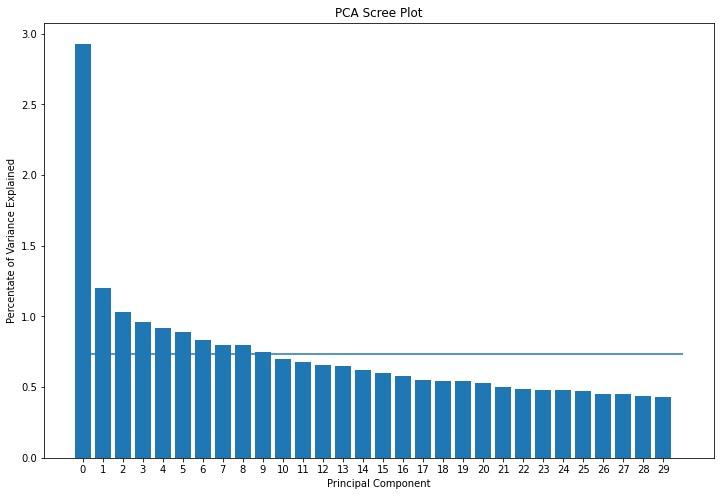

done in 1.314s.


In [66]:
t0 = time()

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
print("Mean Theshold of Component Number:",sum(pca.explained_variance_ratio_)*100/n_pc)
plt.bar(x= range(0,n_pc), height=percent_variance, tick_label=range(0,n_pc))
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.hlines(sum(pca.explained_variance_ratio_)*100/n_pc,0,n_pc)
plt.title('PCA Scree Plot')
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

print("done in %0.3fs." % (time() - t0))

In [69]:

# enumerate splits
for train, test in kf.split(pca_val):
    t0 = time()
    print('train: %s, test: %s' % (train, test))
    X_train, X_test = pca_val[train], pca_val[test]
    y_train, y_test = data_target[train], data_target[test]
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))
    print("done in %0.3fs." % (time() - t0))



train: [ 6170  6171  6172 ... 30845 30846 30847], test: [   0    1    2 ... 6167 6168 6169]
[[6136    8]
 [   0   26]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6144
        True       0.76      1.00      0.87        26

    accuracy                           1.00      6170
   macro avg       0.88      1.00      0.93      6170
weighted avg       1.00      1.00      1.00      6170

0.9987034035656402
done in 137.419s.
train: [    0     1     2 ... 30845 30846 30847], test: [ 6170  6171  6172 ... 12337 12338 12339]
[[5929  161]
 [   3   77]]
              precision    recall  f1-score   support

       False       1.00      0.97      0.99      6090
        True       0.32      0.96      0.48        80

    accuracy                           0.97      6170
   macro avg       0.66      0.97      0.74      6170
weighted avg       0.99      0.97      0.98      6170

0.973419773095624
done in 137.402s.
train: [    0     1     2 ...

In [77]:

t0 = time()

lda = LinearDiscriminantAnalysis()
lda.fit(vector_array,data_target)
lda_val = lda.transform(vector_array)

print("done in %0.3fs." % (time() - t0))

done in 30.111s.


In [81]:
# enumerate splits
for train, test in kf.split(lda_val):
    t0 = time()
    print('train: %s, test: %s' % (train, test))
    X_train, X_test = lda_val[train], lda_val[test]
    y_train, y_test = data_target[train], data_target[test]
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))
    print("done in %0.3fs." % (time() - t0))

train: [ 6170  6171  6172 ... 30845 30846 30847], test: [   0    1    2 ... 6167 6168 6169]
[[6121   23]
 [   0   26]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6144
        True       0.53      1.00      0.69        26

    accuracy                           1.00      6170
   macro avg       0.77      1.00      0.85      6170
weighted avg       1.00      1.00      1.00      6170

0.9962722852512156
done in 24.309s.
train: [    0     1     2 ... 30845 30846 30847], test: [ 6170  6171  6172 ... 12337 12338 12339]
[[6051   39]
 [   3   77]]
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      6090
        True       0.66      0.96      0.79        80

    accuracy                           0.99      6170
   macro avg       0.83      0.98      0.89      6170
weighted avg       1.00      0.99      0.99      6170

0.993192868719611
done in 26.932s.
train: [    0     1     2 ... 3

In [ ]:
for projectName in projectList:
    with open(os.path.join(outDir, outFile), "a") as fo:
        fo.write("{},{},{},{},{},{},{},{},{},{},{}\n".format(projectName, flakyTrain, nonFlakyTrain, flakyTest, nonFlakyTest, avgP, avgR, f1-score, fbeta-score, avgTPrep, avgTPred))